 # Opis notatnika
 Ten notatnik jest kontunacją analizy danych o lotach i ich opóźnieniach. Od tego momentu zaczniemy łączyć posiadana przez nas zbiory danych, będąc w stanie dokonać dodatkowych analiz.

 Zanim jednak do tego przejdziemy, należy, podobnie jak w poprzednim kroku, skonfigurować odpowiednio notatnik.
 
 W tej części warsztatu ponownie wcielasz się w rolę Analiyka Danych, którego zadaniem jest wykonanie analizy eksplotacyjnej zbioru danych - jedno z wymagań dostarczonych przez klienta.

 Tutaj zaimportuj wymagane biblioteki

In [1]:
import mysql.connector as sql
import pandas as pd
import psycopg2
from psycopg2 import sql
import os
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt

 ## Połączenie z bazą danych
 Tutaj uzupełnij konfigurację połączenia

In [2]:
username = ''
password = '' ## trzeba wpisac swoje dane
host = 'localhost'
database= 'airlines'
port = 5432

 Tutaj stwórz zmienną engine, która zostanie użyta do połączenia z bazą danych

In [3]:
url = f'postgresql://{username}:{password}@{host}:{port}/{database}'
engine = create_engine(url)

 Tutaj uzupełnij implementację metody `read_sql_table`

In [4]:
def read_sql_table(table_name, engine, columns=None, 
                   index_col=None, coerce_float=True, parse_dates=None, params=None, chunksize=None):
   
    query = f'SELECT * FROM {table_name}'
   
    
    return pd.read_sql_query(query, engine, index_col=index_col, 
                             coerce_float=coerce_float, parse_dates=parse_dates, params=params, chunksize=chunksize)

 Tutaj zaczytaj zapisaną wcześniej ramkę danych `flight_df` do zmniennej o takiej samej nazwie

In [5]:
flight_df = pd.read_csv("../data/processed/flight_df_01.csv")

Sprawdzenie poprawności danych w ramce `flight_df` 

In [6]:
flight_df_expected_rows_amount = 1057391
flight_df_rows_amount = flight_df.shape[0]

assert flight_df_rows_amount == flight_df_expected_rows_amount, f'Oczekiwano {flight_df_expected_rows_amount} wierszy, otrzymano {flight_df_rows_amount}'

 # Wzbogacenie o `aircraft`
 Używając procedury `read_sql_table` wczytaj dane z tabeli `aircraft` i zapisz jako `aircraft_df`. Następnie:  
 1. Usuń z ramki kolumny `number_of_seats` oraz `id`. Na tej podstawie usuń nadmiarowe wiersze (duplikaty).  
 1. Następnie jeszcze raz sprawdź, czy dla kolumny `tail_num` nie występują duplikaty. Innymi słowy należy sprawdzić, czy dla jednego `tail_num` występuje więcej niż jeden rok produkcji.  
 1. Jeśli tak to:  
     - do ramki `aircraft_df_duplicated` zapisz powielone zgodnie ze sprawdzeniem wiersze,  
     - zgodnie z powyższym zmodyfikuj ramkę tak, aby w przypadku duplikatu za datę wytworzenia samolotu, uznana została najnowsza tj. jeśli dla `tail_num` są dostępne daty produkcji 1998 oraz 2001, uznajemy, że `tail_num` został wyprodukowany w `2001`.

 Wskazówki:
 - Praca z duplikatami na LMS: `Python - analiza danych -> Dzień 5 - Pandas -> Duplikaty`
 - Dokumentacja metody `duplicated`: [klik](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html)
 - Dokumentacja metody `drop_duplicates`: [klik](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html)

 Tutaj wczytaj tabelę `aircraft` używając `read_sql_table`

In [7]:
aircraft_df = read_sql_table('aircraft', engine)

 Tutaj usuń kolumny `number_of_seats`, `id` oraz duplikaty z ramki `aircraft_df`

In [8]:
aircraft_df = aircraft_df.drop(columns=['number_of_seats', 'id']).drop_duplicates()

 ### Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [9]:
aircraft_df_expected_rows = 7364
aircraft_df_expected_columns = set(['tail_num', 'manufacture_year'])

aircraft_df_rows = aircraft_df.shape[0]

diff = aircraft_df_expected_columns.symmetric_difference(set(aircraft_df.columns))
assert aircraft_df_rows == aircraft_df_expected_rows, f'Spodziewano się {aircraft_df_expected_rows} wierszy , otrzymano {aircraft_df_rows} wierszy'

assert diff == set([]), f'Spodziewano się {aircraft_df_expected_columns} kolumn, otrzymano: {aircraft_df_expected_columns} kolumn. Różnica: \n\t{diff}'

 Tutaj sprawdź czy w ramkce `aircraft_df` występują duplikaty wewnątrz kolumny `tail_num`. Czyli czy dla danego `tail_num` występuje więcej niż jeden rok produkcji.

In [10]:
aircraft_df_is_duplicated = aircraft_df.duplicated(subset='tail_num')
aircraft_df_duplicated = aircraft_df.loc[aircraft_df_is_duplicated]
aircraft_df_duplicated

,manufacture_year,tail_num
2086,2000,N783CA
5725,2014,N856GT
6746,2017,N877AS


 ### Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić czy ta część została poprawnie wykonana

In [11]:
aircraft_df_expected_rows = 3
aircraft_df_duplicated_rows = aircraft_df_duplicated.shape[0]
assert aircraft_df_duplicated_rows == aircraft_df_expected_rows, f"Oczekiwano {aircraft_df_expected_rows} wierszy, otrzymano {aircraft_df_duplicated_rows}"

 ## Modyfikacja `aircraft_df`
 Tutaj dokonaj aktualizacji tabeli `aircraft_df` - jeśli jest taka potrzeba. Zrób to tak aby, dla powielonych `tail_num`, `manufacture_year` został ustawiony jako najwyższy

In [12]:
aircraft_df_duplicated['manufacture_year'].unique()

array([2000, 2014, 2017], dtype=int64)

In [13]:
latest_years = aircraft_df.groupby('tail_num')['manufacture_year'].idxmax()
aircraft_df = aircraft_df.loc[latest_years]

In [14]:
aircraft_df

,manufacture_year,tail_num
3896,2006,B708RE
1152,1996,CFEXB
1143,1996,CFEXF
179,1987,CFEXH
203,1987,CFEXI
...,...,...
67,1976,ZS-JIV
73,1978,ZS-OPS
48,1972,ZS-RSC
54,1974,ZS-RSF


 ### Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [15]:
test_tail = 'N783CA'
test_value = aircraft_df.loc[aircraft_df['tail_num']
                             == test_tail]['manufacture_year']
test_value = int(test_value)

expected_value = 2000
assert test_value == expected_value, f"Dla 'tail_num' == '{test_tail}' oczekiwano {expected_value} otrzymano {test_value}"

 ## Połączenie `aircraft_df` oraz `flight_df`
 Połącz ramkę `aircraft_df` oraz `flight_df` zgodnie z kluczem oraz odpowiedz na następujące pytania:
 1. Czy po połączeniu pojawiły się duplikaty? Dokonaj odpowiedniego sprawdzenia.
 1. Wyznacz zależność roku produkcji do częstotliwości opóźnień. Wynik zapisz do tabeli `delays_by_manufacture_year_df`.
 1. Przedstaw wyniki w tabeli za pomocą wykresu punktowego.
 1. Dokonaj modyfikacji w taki sposób, aby wyświetlone na wykresie zostały tylko takie roczniki samolotów, które wykonały łącznie więcej niż 10000 `(>)` lotów.

> **Wskazówka:**
> Aby nie utracić potencjalnie całej dotychczasowej pracy, zapisz wynik do tymczasowej zmiennej np. `tmp_flight_df`. Po sprawdzeniu możesz użyć metody `copy`: [link](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html), aby nadpisać `flight_df` używając `tmp_flight_df`.

 Tutaj dokonaj złączenia `flight_df` z `aircraft_df`, wynik zapisz do `tmp_flight_df`

In [16]:
tmp_flight_df = flight_df.merge(aircraft_df, how='left', left_on='tail_num', right_on='tail_num')

 Tutaj dokonaj sprawdzenia, czy nie pojawiły się duplikaty

In [17]:
tmp_flight_df[tmp_flight_df.duplicated()]

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,is_delayed,is_weekend,distance_agg,manufacture_year


 Tutaj nadpisz `flight_df` używając `tmp_flight_df`

In [18]:
flight_df = tmp_flight_df.copy()

 ## Opóźnienia vs. rok produkcji samolotu cz. 1
 Tutaj wyznacz zależność roku produkcji do częstotliwości opóźnień

In [19]:
delays_by_manufacture_year_df = flight_df.groupby('manufacture_year').agg({
    'arr_delay_new': 'mean',
    'id': 'nunique'
}).reset_index()
delays_by_manufacture_year_df.rename(columns={'id': 'flight_count'}, inplace=True)

In [20]:
delays_by_manufacture_year_df['manufacture_year'] = delays_by_manufacture_year_df['manufacture_year'].astype(int)

 Tutaj wyrysuj ramkę `delays_by_manufacture_year_df`

In [21]:
delays_by_manufacture_year_df.head()

,manufacture_year,arr_delay_new,flight_count
0,1987,13.313770,443
1,1988,15.143533,634
2,1989,41.615385,13
3,1990,13.242405,4786
4,1991,14.260513,7701


 Tutaj zmodyfikuj wykres tak, aby prezentował tylko te roczniki, które odbyły więcej niż 10000 lotów

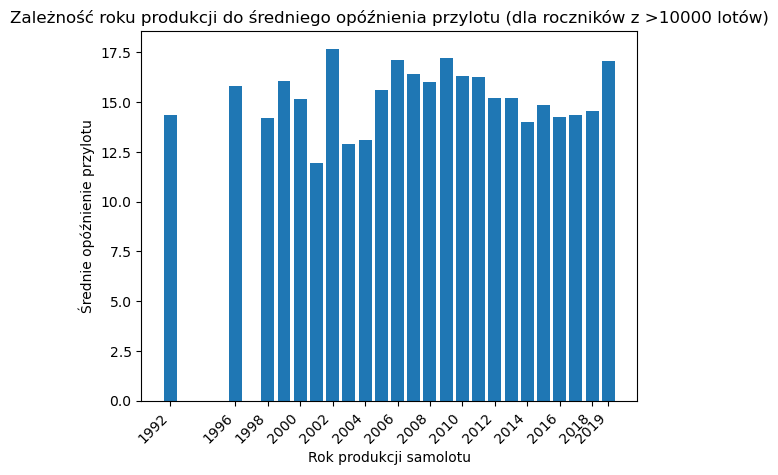

In [22]:
manufacture_years_over_10000_flights = flight_df['manufacture_year'].value_counts()[flight_df['manufacture_year'].value_counts() > 10000].index
filtered_delays_df = delays_by_manufacture_year_df[delays_by_manufacture_year_df
                                                   ['manufacture_year'].isin(manufacture_years_over_10000_flights)]


plt.bar(filtered_delays_df['manufacture_year'], filtered_delays_df['arr_delay_new'])
plt.xlabel('Rok produkcji samolotu')
plt.ylabel('Średnie opóźnienie przylotu')
plt.title('Zależność roku produkcji do średniego opóźnienia przylotu (dla roczników z >10000 lotów)')
plt.xticks([1996.0] + list(filtered_delays_df['manufacture_year'][::2]) + [2019.0], rotation=45, ha='right')

plt.show()

 ## Opóźnienia vs. rok produkcji samolotu cz. 2
 Dokonaj agregacji kolumny `manufacture_year` do kolumny `manufacture_year_agg` zgodnie z poniższym:
 1. Grupując dane co 3 lata -> Czy po grupowaniu można zauważyć zależność? Wyniki zapisz do ramki `flight_delays_by_manufacture_year_agg_df`.
 1. Wyznacz top 5 roczników samolotu, które wykonały najwięcej lotów. Wyniki zapisz do ramki `top_manufactured_df`, do obliczeń wykorzystaj `delays_by_manufacture_year_df`.

 Tutaj dodaj kolumnę `manufacture_year_agg` do ramki `flight_df`

In [23]:
flight_df['manufacture_year_agg'] = flight_df['manufacture_year'] // 3 * 3

 Tutaj stwórz zmienną `flight_delays_by_manufacture_year_agg_df`

In [24]:
flight_delays_by_manufacture_year_agg_df = flight_df.groupby('manufacture_year_agg').agg({
    'arr_delay_new': 'mean',
    'id': 'nunique'
}).round(2).reset_index()

In [25]:
flight_delays_by_manufacture_year_agg_df.rename(columns={'id': 'flight_count'}, inplace=True)
flight_delays_by_manufacture_year_agg_df['manufacture_year_agg'] = flight_delays_by_manufacture_year_agg_df['manufacture_year_agg'].astype(int)

In [26]:
flight_delays_by_manufacture_year_agg_df.head(1)

,manufacture_year_agg,arr_delay_new,flight_count
0,1986,14.39,1077


 Tutaj stwórz wykres w oparciu o dane zawarte w `flight_delays_by_manufacture_year_agg_df`

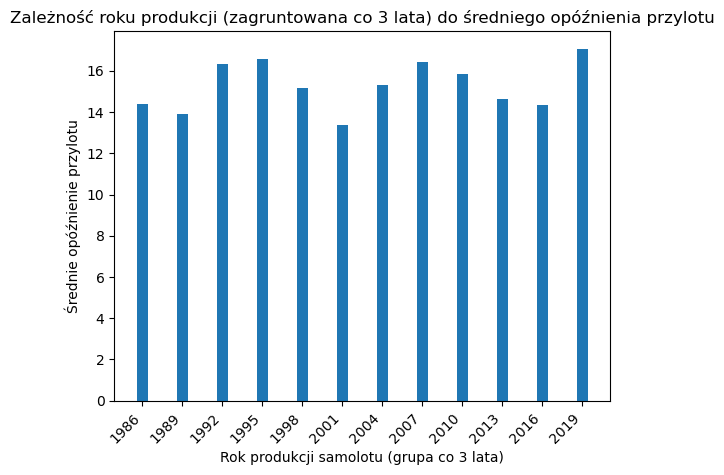

In [27]:
plt.bar(flight_delays_by_manufacture_year_agg_df['manufacture_year_agg'], 
        flight_delays_by_manufacture_year_agg_df['arr_delay_new'])
plt.xlabel('Rok produkcji samolotu (grupa co 3 lata)')
plt.ylabel('Średnie opóźnienie przylotu')
plt.title('Zależność roku produkcji (zagruntowana co 3 lata) do średniego opóźnienia przylotu')
plt.xticks(flight_delays_by_manufacture_year_agg_df['manufacture_year_agg'], rotation=45, ha='right')
plt.show()

Tutaj wyznacz TOP 5 roczników produkcji - czyli sortując według liczby wykonanych lotów, pamiętaj o wyświetleniu również wartości opóźnienia.

In [28]:
top_manufactured_df = delays_by_manufacture_year_df.nlargest(5, 'flight_count')

print("TOP 5 roczników samolotów pod względem wykonanych lotów:")
top_manufactured_df

TOP 5 roczników samolotów pod względem wykonanych lotów:


,manufacture_year,arr_delay_new,flight_count
14,2001,11.928360,100251
29,2016,14.271123,66191
30,2017,14.333767,62353
27,2014,14.001917,61128
28,2015,14.874228,58426


In [29]:
flight_df.to_csv('../data/processed/flight_df_02.csv', index=False)

 Tutaj zapisz ramkę w najdogodniejszy sposób